# Классификация цифр на цветном изображении

In [1]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms

import GPyOpt
from support import train_model, compute_loss_accuracy, Flattener, CNN

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print("CUDA")
else:
    device = torch.device('cpu')
    print("CPU")

CPU


Загружаем тренировочные и тестовые данные

In [8]:
# First, lets load the dataset
data_train = dset.SVHN('./data/', download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])
                       ])
                      )

  0%|          | 0/182040794 [00:00<?, ?it/s]

Разделяем данные на training и validation.

Разделяем данные на training и validation.

In [9]:
batch_size = 64

data_size = data_train.data.shape[0]
print(f"Изначальный размер тренировочных данных {data_size}")
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]
print(f"Размер валидационных данных {len(val_indices)}")
print(f"Новый размер тренировочных данных {len(train_indices)}")

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

Изначальный размер тренировочных данных 73257
Размер валидационных данных 14651
Новый размер тренировочных данных 58606


# Аугментация данных (Data augmentation)

Ниже мы используем следующие алгоритмы генерации:
- ColorJitter - случайное изменение цвета
- RandomRotation - случайный поворот

c:\code\python\study\dl_research\venv\lib\site-packages\torchvision\transforms\transforms.py:1249: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


Using downloaded and verified file: ./data/train_32x32.mat


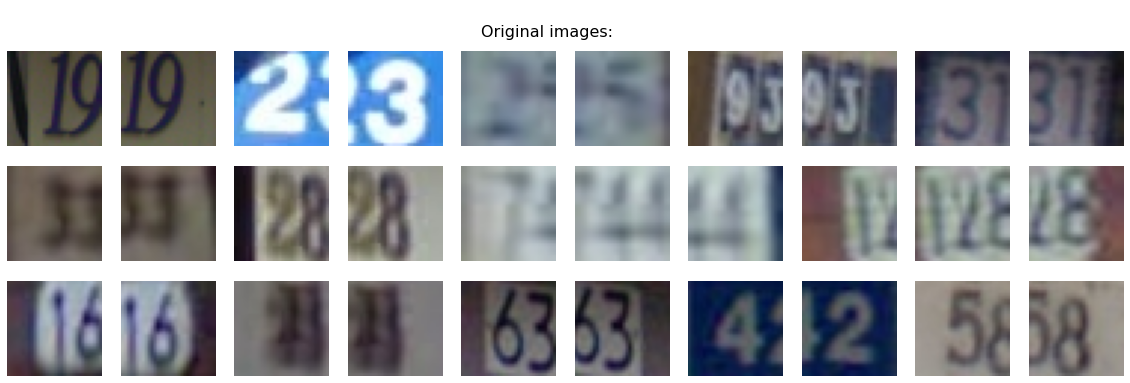

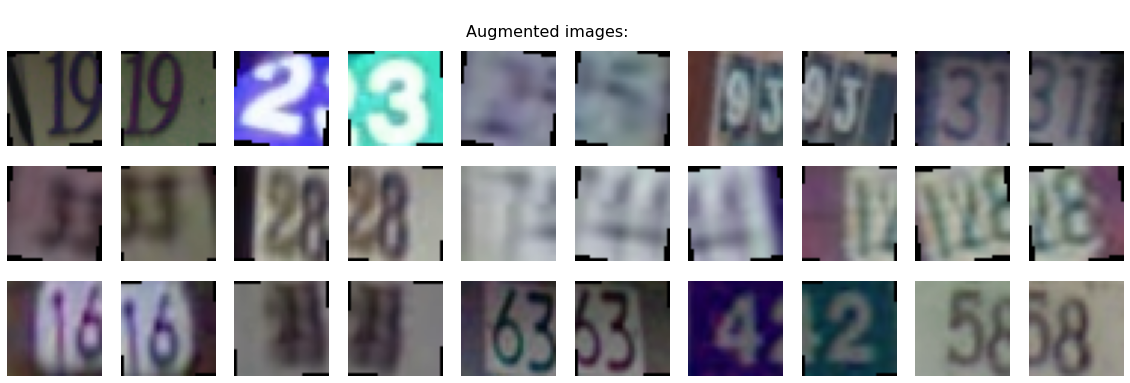

In [13]:
rows = 3
cols = 10

fig = plt.figure(figsize=(20, 6))
fig.suptitle('\nOriginal images:', fontsize=16)

for i, (x, y) in enumerate(dset.SVHN('./data/')):
    if i == rows * cols:
        break
    plt.subplot(rows, cols, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')


# -----------------------------------------------------------------


tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR)
])
data_aug_vis = dset.SVHN('./data/', download=True, transform=tfs)

fig = plt.figure(figsize=(20, 6))
fig.suptitle('\nAugmented images:', fontsize=16)

for i, (x, y) in enumerate(data_aug_vis):
    if i == rows * cols:
        break
    plt.subplot(rows, cols, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

Применяем выбранную аугментацию к тренировочному набору

In [14]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47], std=[0.20,0.20,0.20])
])

data_aug_train = dset.SVHN('./data/', transform=tfs)
train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, sampler=train_sampler)

# Создание архитектуры сети

In [2]:
model = CNN()
model.eval()

CNN(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Flattener()
    (12): Linear(in_features=1600, out_features=128, bias=True)
    (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True)
    (15): Linear(in_features=128, out_features=10, bia

# Тренировка сети с байесовской оптимизацией гиперпараметров

In [ ]:
# Скорость обучения
learning_rate_min_degree = -4
learning_rate_max_degree = -2
learning_rate_min = 10 ** learning_rate_min_degree
learning_rate_max = 10 ** learning_rate_max_degree

# L2 регуляризация
weight_decay_min_degree = -5
weight_decay_max_degree = -3
weight_decay_min = 10 ** weight_decay_min_degree
weight_decay_max = 10 ** weight_decay_max_degree

# Усечение learning_rate
factor_min = 0.2
factor_max = 0.5
factor_middle = (factor_max - factor_min) / 2

# Количество эпох без улучшения, после которых скорость обучения будет снижена.
patience_min = 1
patience_max = 3
patience_middle = (patience_max - patience_min) // 2

domain =[{'name': 'learning_rate', 'type': 'continuous', 'domain': (learning_rate_min, learning_rate_max)},
         {'name': 'weight_decay', 'type': 'continuous', 'domain': (weight_decay_min, weight_decay_max)},
         {'name': 'factor', 'type': 'continuous', 'domain': (factor_min, factor_max)},
         {'name': 'patience', 'type': 'discrete', 'domain': np.arange(patience_min, patience_max, 1)}]

epochs = 20

best_model = None
best_val_acc = None
best_itteration = None

history_search_loss = np.array([])
history_search_hiperparams = np.array([])

for i in range(10):
  # Загружаем новую модель
  model = CNN()
  model.type(torch.cuda.FloatTensor)
  model.to(device)

  # Предсказываем оптимальные параметры
  if i != 0:
    bo_step = GPyOpt.methods.BayesianOptimization(f = None, domain = domain, X = history_search_hiperparams, Y = history_search_loss)
    next_step = bo_step.suggest_next_locations()
    learning_rate, weight_decay, factor, patience = next_step[0][0], next_step[0][1], next_step[0][2], next_step[0][3]

  else:
    learning_rate = 10 ** np.random.randint(learning_rate_min_degree, learning_rate_max_degree + 1)
    weight_decay  = 10 ** np.random.randint(weight_decay_min_degree, weight_decay_max_degree + 1)
    factor        = np.random.uniform(factor_min, factor_max)
    patience      = np.random.randint(patience_min, patience_max + 1)

  print("-------------------------------")
  print(f"Итерация {i + 1}")
  print(f"Тренировочные параметры: learning_rate = {learning_rate}, weight_decay = {weight_decay}, factor = {factor}, patience = {patience}")
  print("")

  # Тренируем модель
  loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
  optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=factor, patience=patience, verbose=True)

  %time train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(model, train_aug_loader, val_loader, loss, optimizer, epochs, device, scheduler=scheduler, scheduler_loss=True)

  # Обновляем банк данных
  if i != 0:
    history_search_loss = np.vstack((history_search_loss, np.array([[val_loss_history[-1]]])))
    history_search_hiperparams = np.vstack((history_search_hiperparams, np.array([[learning_rate, weight_decay, factor, patience]])))
  else:
    history_search_loss = np.array([[val_loss_history[-1]]])
    history_search_hiperparams = np.array([[learning_rate, weight_decay, factor, patience]])

  #Обновляем лучшие результаты
  if best_val_acc is None:
    best_model = model
    best_val_acc = val_acc_history[-1]
    best_itteration = i
    print(f"Новая лучшая точность: {best_val_acc}")
    continue

  elif best_val_acc < val_acc_history[-1]:
    best_model = model
    best_val_acc = val_acc_history[-1]
    best_itteration = i
    print(f"Новая лучшая точность: {best_val_acc}")

Сохраняем модель для последующих тестов

In [ ]:
torch.save(best_model, "./model_svhn_bo1.pth")